In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
import numpy as np
import os

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device used: {device.type}')

Device used: cpu


# Hyperparameters for project

In [2]:
train_size = 0.9                    # In percent
test_size = 1 - train_size          # In percent, calculated dynamically from train_size
num_epochs = 4                     # Number of epochs for the training of the nn
batch_size = 128                     # Size of batches
learning_rate = 0.0001               # Learningrate -> subject to change -> learning rate schedule

# Data preprocessing


## Import the dataset
Dataset should be imported as a pytorch dataloader for batch optimization

In [3]:
# Create an empty array to store the image arrays and class
X = []
Y = []

# Define the folder paths containing the images
folder_paths = ['Dataset/Non_Demented/', 'Dataset/Very_Mild_Demented/', 'Dataset/Mild_Demented/', 'Dataset/Moderate_Demented/']
classes = [r'Non demented', r'Very mildly demented', r'mild demented', r'moderate demented']

# Loop over the images to save them in the list
for c, path in enumerate(folder_paths):
    items = os.listdir(path)
    for picture in items:
        file_path = os.path.join(path, picture)
        # Open the image and convert it to a NumPy array
        img = Image.open(file_path)
        array_representation = np.asarray(img)

        # Append the NumPy array to the list
        X.append(array_representation)
        Y.append(c)

# Convert the list of image arrays to a NumPy array
X = np.array(X)
X = X.reshape(len(X), 128, 128, 1)

# Dynamically calculate the number of classes in dataset
num_classes = len(np.unique(Y))

# Shape of the array
print(np.shape(X))

(6400, 128, 128, 1)


In [4]:
X = X / 256

### Split into Test/Training sets

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 1 - train_size, stratify=Y, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 1 - train_size, stratify=Y_train, random_state=42)

for i in np.unique(Y_train):
    print(f"Elements of {i} in X_train: {np.count_nonzero(Y_train == i)}")
print()
for i in np.unique(Y_test):
    print(f"Elements of {i} in X_test: {np.count_nonzero(Y_test == i)}")
print()
for i in np.unique(Y_val):
    print(f"Elements of {i} in X_val: {np.count_nonzero(Y_val == i)}")

Elements of 0 in X_train: 2592
Elements of 1 in X_train: 1814
Elements of 2 in X_train: 726
Elements of 3 in X_train: 52

Elements of 0 in X_test: 320
Elements of 1 in X_test: 224
Elements of 2 in X_test: 90
Elements of 3 in X_test: 6

Elements of 0 in X_val: 288
Elements of 1 in X_val: 202
Elements of 2 in X_val: 80
Elements of 3 in X_val: 6


In [6]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# Assuming you have a class named MyDataset for your dataset
class MyDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        label = self.Y[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

# Define transformations, you can adjust these based on your needs
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to PyTorch tensor
])

# Create an instance of your dataset
dataset_train = MyDataset(X=X_train, Y=Y_train, transform=transform)
dataset_val = MyDataset(X=X_val, Y=Y_val, transform=transform)
dataset_test = MyDataset(X=X_test, Y=Y_test, transform=transform)

# Define DataLoader for training, validation and test sets
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [7]:
# from torch.utils.data import Subset

# train_dataset, test_dataset = torch.utils.data.random_split(
#         dataset, [int(train_size * len(dataset)), len(dataset) - int(train_size * len(dataset))],
#     )

# train_size_total = int(train_size * len(train_dataset))

# # Create indices for the entire dataset
# indices = list(range(len(train_dataset)))
# np.random.shuffle(indices)

# # Use the indices for the random_split
# train_indices, val_indices = indices[:train_size_total], indices[train_size_total:]

# validation_dataset = Subset(train_dataset, val_indices)
# train_dataset = Subset(train_dataset, train_indices)

# # Define DataLoader for training, validation and test sets
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# # validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# # Get the indices of items in the train_dataset
# _indices = train_dataset.indices

# # Extract the targets (labels) for the corresponding indices as a NumPy array
# _targets_np = np.array([dataset.Y[idx] for idx in _indices])

# # Count the occurrences of each class in the train dataset using numpy.unique
# class_labels, class_counts = np.unique(_targets_np, return_counts=True)

# # Display the number of items in each class
# for class_label, count in zip(class_labels, class_counts):
#     print(f"Class {class_label}: {count} items")

In [9]:
# from torch.utils.data import SubsetRandomSampler
# from sklearn.model_selection import train_test_split

# selected_labels = [Y[i] for i in train_dataset.indices]

# # Use sklearn's train_test_split to perform a stratified split
# train_indices, val_indices = train_test_split(
#     range(len(train_dataset)),
#     test_size=1 - train_size,
#     stratify=selected_labels,
#     random_state=42,
# )

# # Define the samplers for DataLoader
# train_sampler = SubsetRandomSampler(train_indices)
# val_sampler = SubsetRandomSampler(val_indices)

# # Create DataLoader instances using the samplers
# train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
# val_loader = DataLoader(dataset, batch_size=batch_size, sampler= val_sampler)

In [10]:
# # Get the indices of items in the train_dataset
# _indices = train_sampler.indices

# # Extract the targets (labels) for the corresponding indices as a NumPy array
# _targets_np = np.array([dataset.Y[idx] for idx in _indices])

# # Count the occurrences of each class in the train dataset using numpy.unique
# class_labels, class_counts = np.unique(_targets_np, return_counts=True)

# # Display the number of items in each class
# for class_label, count in zip(class_labels, class_counts):
#     print(f"Class {class_label}: {count} items")

### Show example of dataset

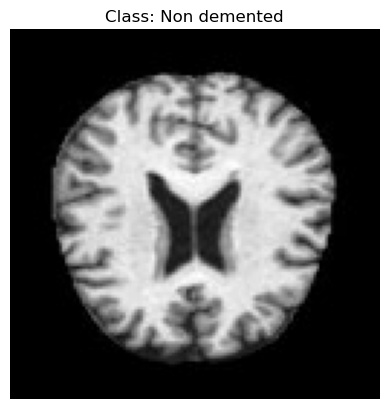

In [11]:
index_to_display = 0  # Image to show in dataset

# Get the image array and corresponding class
selected_image = X[index_to_display]
selected_class = classes[Y[index_to_display]]

# Display the image
plt.imshow(selected_image, cmap='gray')
plt.title(f'Class: {selected_class}')
plt.axis('off')  # Turn off axis labels
plt.show()

## Data augmentation

## Data normalization

# Architecture of the network

In [12]:
class ConvNet(nn.Module):
    def __init__(self, in_channels, nb_filters, kernel_size_conv, fc_size, fc_out_features, pooling_size = [1, 1], activation_function = F.relu, dropout_rate_conv = 0.2, dropout_rate_fc = 0.2):
        '''
        in_channels         : The dimension of colors (grayscale = 1, rbg = 3)
        nb_filters          : Number of filters applied to first layer
        kernel_size_conv    : Size of the convolution of the first layer
        fc_size             : Size of the first fully connected layer (output)
        fc_out_features     : Number of classes of the dataset
        pooling_size        : Pooling size, default set to (1,1)
        activation_function : Set the activation function for the layers, default is ReLU
        '''

        # Define layers in the network
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, nb_filters, kernel_size_conv)
        self.dropout1 = nn.Dropout2d(p=dropout_rate_conv)
        self.conv2 = nn.Conv2d(nb_filters, nb_filters, int(kernel_size_conv / 2))
        self.dropout2 = nn.Dropout2d(p=dropout_rate_conv)
        self.pool = nn.MaxPool2d(pooling_size[0], pooling_size[1])

        # Initialize these sizes for the fully connected layer and calculate this dynamically later in the first forward pass
        self.input_size = None                  # Will later be the size of the image input
        self.fc_size_input = None               # Will later be the size of the output of the last cnn layer (after pooling)

        # Dummy values for Linear layers; will be updated in the first forward pass
        self.fc1 = nn.Linear(1, 1)
        self.fc2 = nn.Linear(1, 1)
        self.fc3 = nn.Linear(1, 1)

        # Dropout for fully connected layers
        self.dropout_fc1 = nn.Dropout(p=dropout_rate_fc)
        self.dropout_fc2 = nn.Dropout(p=dropout_rate_fc)

        # Set some variables for the forward pass
        self.activation_function = activation_function
        self.fc_size = fc_size
        self.fc_out_features = fc_out_features
        self.pooling_size = pooling_size

    def forward(self, x):
        # Set the input size dynamically during the first forward pass
        if self.input_size is None:
            self.input_size = x.size(2)
            self.fc_size_input = self.calculate_fc_size(self.conv1.out_channels, self.conv1.kernel_size[0])
            self.fc1 = nn.Linear(self.fc_size_input, self.fc_size)
            self.fc2 = nn.Linear(self.fc_size, int(self.fc_size / 2))
            self.fc3 = nn.Linear(int(self.fc_size / 2), self.fc_out_features)

        # x = self.pool(self.activation_function(self.conv1(x)))
        x = self.pool(self.activation_function(self.dropout1(self.conv1(x))))
        # x = self.pool(self.activation_function(self.conv2(x)))
        x = self.pool(self.activation_function(self.dropout2(self.conv2(x))))
        
        x = x.view(-1, self.fc_size_input)
        # x = F.relu(self.fc1(x))
        x = F.relu(self.dropout_fc1(self.fc1(x)))
        # x = F.relu(self.fc2(x))
        x = F.relu(self.dropout_fc2(self.fc2(x)))
        x = self.fc3(x)
        return x

    def calculate_fc_size(self, nb_filters, kernel_size_conv):
        # Calculate the dynamic input size for fully connected layer
        conv_output_size1 = self.calculate_conv_output_size(self.input_size, kernel_size_conv)
        conv_output_size2 = self.calculate_conv_output_size(conv_output_size1, int(kernel_size_conv / 2))
        pooled_output_size = self.calculate_conv_output_size(conv_output_size2, self.pooling_size[0])
        fc_size = nb_filters * pooled_output_size ** 2
        return fc_size

    def calculate_conv_output_size(self, input_size, kernel_size, padding = 0, stride = 1):
        # Calculate the output size of the convolutional layer
        return int(np.floor((input_size - kernel_size + 2 * padding) / stride) + 1)


model = ConvNet(in_channels=1, nb_filters=6, kernel_size_conv=4, fc_size = 64, fc_out_features=num_classes)
model.train()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_total_steps = train_loader.__len__()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.float()
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)        
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if ((i+1) % (int(n_total_steps / 4)) == 0) or (i+1 == n_total_steps):
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}, training')

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)


with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(num_classes)]
    n_class_samples = [0 for i in range(num_classes)]
    for images, labels in test_loader:
        images = images.float()
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(num_classes):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

print()
model.eval()
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(num_classes)]
    n_class_samples = [0 for i in range(num_classes)]
    for images, labels in test_loader:
        images = images.float()
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network in eval mode: {acc} %')

    for i in range(num_classes):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Epoch [1/4], Step [10/41], Loss: 1.3613, training
Epoch [1/4], Step [20/41], Loss: 1.3469, training
Epoch [1/4], Step [30/41], Loss: 1.3447, training
Epoch [1/4], Step [40/41], Loss: 1.3554, training
Epoch [1/4], Step [41/41], Loss: 1.3403, training
Epoch [2/4], Step [10/41], Loss: 1.3457, training
Epoch [2/4], Step [20/41], Loss: 1.3507, training
Epoch [2/4], Step [30/41], Loss: 1.3678, training
Epoch [2/4], Step [40/41], Loss: 1.3384, training
Epoch [2/4], Step [41/41], Loss: 1.3459, training
Epoch [3/4], Step [10/41], Loss: 1.3530, training
Epoch [3/4], Step [20/41], Loss: 1.3480, training
Epoch [3/4], Step [30/41], Loss: 1.3274, training
Epoch [3/4], Step [40/41], Loss: 1.3380, training
Epoch [3/4], Step [41/41], Loss: 1.3605, training
Epoch [4/4], Step [10/41], Loss: 1.3427, training
Epoch [4/4], Step [20/41], Loss: 1.3524, training
Epoch [4/4], Step [30/41], Loss: 1.3498, training
Epoch [4/4], Step [40/41], Loss: 1.3589, training
Epoch [4/4], Step [41/41], Loss: 1.3420, training
